In [1]:
"""

Skript zur generierung von CFADS

"""

print ('_')

_


In [155]:
#!/usr/bin/env python

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import pandas as pd
import wradlib
from scipy import stats
import matplotlib.cm as cm
my_cmap = cm.get_cmap('jet',40)
my_cmap.set_under('lightgrey')
my_cmap.set_over('darkred')
from pcc import get_miub_cmap as my_cmap
from pcc import plot_radar
from pcc import boxpol_pos
from pcc import plot_borders
import wradlib as wrl
from osgeo import osr
from satlib import ipoli_radi
from satlib import corcor
Pos = boxpol_pos()
blon0, blat0 = Pos['lon_ppi'], Pos['lat_ppi']
bbx, bby = Pos['gkx_ppi'], Pos['gky_ppi']

#% matplotlib inline

print ("_")

_


# Einlesen von BoXPol Daten
------------------------

In [156]:
#ZP = '20170519110333'
ZP = '20141213140000'
#ZP = '20150330233003'

def CFAD(ZP):
    
    data_, height_ = np.array([]),np.array([])
    
    year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]

    deg_scan =  ["/ppi_1p5deg/","/ppi_2p4deg/","/ppi_3p4deg/",
                 "/n_ppi_010deg/","/n_ppi_045deg/",
                 "/n_ppi_082deg/","/n_ppi_110deg/","/n_ppi_140deg/",
                 "/n_ppi_180deg/","/n_ppi_280deg/"]
    
    for ds in deg_scan:
        
        #print ds
        if year<'2015':
            rad_path = 'radar-archiv'
            
        else:
            rad_path = 'radar'
            
        ppi_datapath=glob.glob('/automount/'+rad_path+'/scans/' + year+ "/" +
                                   year +"-"+ m + "/" + year+ "-" + m +"-"+ d +
                                   ds+ year + "-" + m +"-"+ d + "--" +ht +
                                   ":"+mt+":"+st+",*.mvol")
            
            
            
            
            
        
        ppi_datapath = ppi_datapath[0]

        #[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']
        ppi=h5py.File(ppi_datapath,'r')
        data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)
        print (data[u'SCAN0'].keys())
        data_boxpol = data[u'SCAN0'][u'ZH']['data']
        r = attrs['SCAN0']['r']
        az = attrs['SCAN0']['az']
        lon_ppi = attrs['VOL']['Longitude']
        lat_ppi = attrs['VOL']['Latitude']
        alt_ppi = attrs['VOL']['Height']
        el_ppi = attrs['SCAN0']['elevation']

        radar_location = (lon_ppi, lat_ppi, alt_ppi)
        elevation = el_ppi
        azimuths = az
        ranges = r
        polargrid = np.meshgrid(ranges, azimuths)
        lon, lat, alt = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1],
                                                         elevation, radar_location)
        #print alt.shape, data_boxpol.shape
        x2 = alt.reshape(alt.shape[0]*alt.shape[1])
        x1 = data_boxpol.reshape(data_boxpol.shape[0]*data_boxpol.shape[1])
        
        height_ = np.append(height_,x2)
        data_ = np.append(data_,x1)

    #print data[u'SCAN0'].keys()
    return data_, height_


In [157]:
ZP = '20170519110333'
#ZP = '20141213140000'
#ZP = '20150330233003'

def CFAD_new(ZP):
    """ AB APRIL 2017 DATA"""
    
    data_, height_ = np.array([]),np.array([])
    
    year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]

    deg_scan = ["/n_ppi_010deg/",  "/n_ppi_045deg/", "/n_ppi_110deg/",  "/n_ppi_280deg/",
                "/n_ppi_020deg/",  "/n_ppi_060deg/", "/n_ppi_140deg/",
                "/n_ppi_031deg/",  "/n_ppi_082deg/",  "/n_ppi_180deg/"]

    
    for ds in deg_scan:
        
        rad_path = 'radar'
            
        ppi_datapath=sorted(glob.glob('/automount/'+rad_path+'/scans/' + year+ "/" +
                               year +"-"+ m + "/" +
                               year+ "-" + m +"-"+ d +
                               ds +
                               '*'+ year +  m + d +ht + mt[0:1]+'*'))
            
            
            
            
            
        
        ppi_datapath = ppi_datapath[0]
        print ppi_datapath

        #[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']
        ppi=h5py.File(ppi_datapath,'r')
        data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)
        print (data[u'SCAN0'].keys())
        data_boxpol = data[u'SCAN0'][u'ZH']['data']
        rhohv = data[u'SCAN0'][u'RHOHV']['data']
        zdr = data[u'SCAN0'][u'ZDR']['data']
        
        #data_boxpol[rhohv<0.95]=np.nan
        #data_boxpol[zdr<0]=np.nan
        #data_boxpol[zdr> 1]=np.nan
        
        r = attrs['SCAN0']['r']
        az = attrs['SCAN0']['az']
        lon_ppi = attrs['VOL']['Longitude']
        lat_ppi = attrs['VOL']['Latitude']
        alt_ppi = attrs['VOL']['Height']
        el_ppi = attrs['SCAN0']['elevation']

        radar_location = (lon_ppi, lat_ppi, alt_ppi)
        elevation = el_ppi
        azimuths = az
        ranges = r
        polargrid = np.meshgrid(ranges, azimuths)
        lon, lat, alt = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1],
                                                         elevation, radar_location)
        #print alt.shape, data_boxpol.shape
        x2 = alt.reshape(alt.shape[0]*alt.shape[1])
        x1 = data_boxpol.reshape(data_boxpol.shape[0]*data_boxpol.shape[1])
        
        height_ = np.append(height_,x2)
        data_ = np.append(data_,x1)

    #print data[u'SCAN0'].keys()
    return data_, height_


In [161]:
x1, x2 = CFAD_new(ZP)
x1[x1<-15] = np.nan

/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_010deg/n_ppi_010deg_12345_20170519110333_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_045deg/n_ppi_045deg_12345_20170519110209_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_110deg/n_ppi_110deg_12345_20170519110120_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_280deg/n_ppi_280deg_12345_20170519110034_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']
/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_020deg/n_ppi_020deg_12345_20170519110300_00.h5


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_060deg/n_ppi_060deg_12345_20170519110152_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_140deg/n_ppi_140deg_12345_20170519110104_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_031deg/n_ppi_031deg_12345_20170519110235_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_082deg/n_ppi_082deg_12345_20170519110136_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_180deg/n_ppi_180deg_12345_20170519110049_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:60: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


In [162]:
def get_my_cmap():
    import matplotlib.cm as cm
    my_cmap = cm.get_cmap('jet',40)
    my_cmap.set_under('white')
    my_cmap.set_over('darkred')
    return my_cmap

def plot_cfad(x1, x2, ZP,vmaxi=None, bini=100):
    """
    Plot 4 CFAD
    """
    
    m1 = ~np.isnan(x1) & ~np.isnan(x2)
    
    x3 = np.array([]); x4 = np.array([]); x5 = np.array([])

    hh = np.array([])
    for jj in range(0,20000,50):
        hh = np.append(hh,jj)
        #x3 = np.append(x3,np.nanmean(x1[np.where((x2>jj)&(x2<jj+100))]))
        x4 = np.append(x4,np.nanmedian(x1[np.where((x2>jj)&(x2<jj+100))]))
    
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(1,1,1)
    plt.hist2d(x1[m1], x2[m1],bins=bini, cmap=get_my_cmap(), vmin=0.1,vmax=vmaxi)
    #plt.hist2d(x1[m1], x2[m1],bins=120, cmap='inferno')
    #plt.hist2d(x1[m1], x2[m1], bins=111, cmap='inferno')
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('', fontsize=20, rotation=0)
    cbar.ax.tick_params(labelsize=20) 
    plt.xlabel(r'$Z_H$ in DBz', fontsize=20)
    plt.ylabel('Height in m', fontsize=20)
    plt.title('Elevation: all', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.plot(x3,hh, linewidth=2, label='mean')
    plt.plot(x4,hh, linewidth=3,color='black', label='median')
    plt.ylim(0,7000)
    plt.xlim(0,50)
    
    # Major ticks every 20, minor ticks every 5
    major_xticks = np.arange(0, 50, 10)
    minor_xticks = np.arange(0, 50, 5)
    major_yticks = np.arange(0, 7000, 1000)
    minor_yticks = np.arange(0, 7000, 200)

    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor=True)
    ax.set_yticks(major_yticks)
    ax.set_yticks(minor_yticks, minor=True)

    # And a corresponding grid
    ax.grid(which='both')

    # Or if you want different settings for the grids:
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=0.8)

    
    
    #plt.legend(loc='upper right', fontsize=10)
    #plt.grid(color='white')
    #plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/boxpol_cfad_'+ZP+'.png')
    #plt.close()
    #plt.savefig('/automount/ftp/velibor/validation/__irs_cfad.png')
    
    plt.show()


In [182]:
plot_cfad(x1,x2,'20141007023744', vmaxi= 920, bini=159)


# IDEE erstelle 2d Feld von BB höhen mit dem BoXPol Volumenscan

In [655]:
ZP = '20170519110333'
#ZP = '20141213140000'
#ZP = '20150330233003'

def CFAD_newtest(ZP):
    """ AB APRIL 2017 DATA"""
    
    data_, height_ = np.array([]),np.array([])
    data2_ = np.array([])
    lon_, lat_ = np.array([]),np.array([])
    
    year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]

    deg_scan = ["/n_ppi_010deg/",  "/n_ppi_045deg/", "/n_ppi_110deg/",  "/n_ppi_280deg/",
                "/n_ppi_020deg/",  "/n_ppi_060deg/", "/n_ppi_140deg/",
                "/n_ppi_031deg/",  "/n_ppi_082deg/",  "/n_ppi_180deg/"]

    
    for ds in deg_scan:
        
        rad_path = 'radar'
            
        ppi_datapath=sorted(glob.glob('/automount/'+rad_path+'/scans/' + year+ "/" +
                               year +"-"+ m + "/" +
                               year+ "-" + m +"-"+ d +
                               ds +
                               '*'+ year +  m + d +ht + mt[0:1]+'*'))
            
            
            
            
            
        
        ppi_datapath = ppi_datapath[0]
        print ppi_datapath

        #[u'PHIDP', u'ZH', u'VV', u'VH', u'UV', u'WH', u'WV', u'UH', u'RHOHV', u'ZV', u'ZDR', u'KDP']
        ppi=h5py.File(ppi_datapath,'r')
        data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)
        print (data[u'SCAN0'].keys())
        data_boxpol = data[u'SCAN0'][u'ZH']['data']
        data_boxpol2 = data[u'SCAN0'][u'ZDR']['data']
        rhohv = data[u'SCAN0'][u'RHOHV']['data']
        zdr = data[u'SCAN0'][u'ZDR']['data']
        
        #data_boxpol[rhohv<0.95]=np.nan
        #data_boxpol[zdr<0]=np.nan
        #data_boxpol[zdr> 1]=np.nan
        
        r = attrs['SCAN0']['r']
        az = attrs['SCAN0']['az']
        lon_ppi = attrs['VOL']['Longitude']
        lat_ppi = attrs['VOL']['Latitude']
        alt_ppi = attrs['VOL']['Height']
        el_ppi = attrs['SCAN0']['elevation']

        radar_location = (lon_ppi, lat_ppi, alt_ppi)
        elevation = el_ppi
        azimuths = az
        ranges = r
        polargrid = np.meshgrid(ranges, azimuths)
        lon, lat, alt = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1],
                                                         elevation, radar_location)
        #print alt.shape, data_boxpol.shape
        x2 = alt.reshape(alt.shape[0]*alt.shape[1])
        x1 = data_boxpol.reshape(data_boxpol.shape[0]*data_boxpol.shape[1])
        x3 = data_boxpol2.reshape(data_boxpol2.shape[0]*data_boxpol2.shape[1])
        lon = lon.reshape(alt.shape[0]*alt.shape[1])
        lat = lat.reshape(alt.shape[0]*alt.shape[1])
        
        height_ = np.append(height_,x2)
        data_ = np.append(data_,x1)
        data2_ = np.append(data2_,x3)
        lon_ = np.append(lon_,lon)
        lat_ = np.append(lat_,lat)

    #print data[u'SCAN0'].keys()
    return data_, height_, data2_, lon_, lat_


In [729]:
x1, x2, x3, lon, lat = CFAD_newtest(ZP)
x1[x1 < 0] = np.nan
x3[x3 <  -5] = np.nan

/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_010deg/n_ppi_010deg_12345_20170519110333_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_045deg/n_ppi_045deg_12345_20170519110209_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_110deg/n_ppi_110deg_12345_20170519110120_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_280deg/n_ppi_280deg_12345_20170519110034_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']
/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_020deg/n_ppi_020deg_12345_20170519110300_00.h5


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_060deg/n_ppi_060deg_12345_20170519110152_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_140deg/n_ppi_140deg_12345_20170519110104_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_031deg/n_ppi_031deg_12345_20170519110235_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_082deg/n_ppi_082deg_12345_20170519110136_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


/automount/radar/scans/2017/2017-05/2017-05-19/n_ppi_180deg/n_ppi_180deg_12345_20170519110049_00.h5
[u'PHIDP', u'ZH', u'VV', u'VH', u'ZDR', u'WV', u'CMAP', u'RHOHV', u'UZH', u'ZV', u'WH', u'KDP', u'UZV']


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:63: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.


In [730]:
lon.shape, lat.shape

((2360520,), (2360520,))

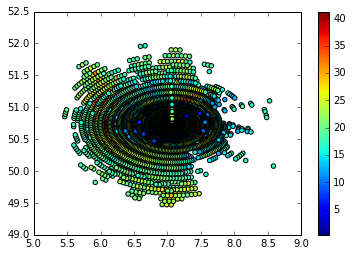

In [731]:
plt.scatter(lon[::100],lat[::100], c=x1[::100])
plt.colorbar()
plt.show()


In [732]:
lon.shape,lat.shape,x2.shape,x1.shape

((2360520,), (2360520,), (2360520,), (2360520,))

In [733]:
% matplotlib inline

In [734]:
x,y = np.arange(4,10,0.1), np.arange(49,53,0.1)
print (x.shape, y.shape)
xx, yy = np.meshgrid(x,y)
print (xx.shape, yy.shape)

proj_stereo = wrl.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

xx,yy = wradlib.georef.reproject(xx, yy,
                                            projection_target=proj_stereo ,
                                            projection_source=proj_wgs)
lon, lat = wradlib.georef.reproject(lon, lat,
                                            projection_target=proj_stereo ,
                                            projection_source=proj_wgs)

bb_boxpol = np.zeros(xx.shape)
print (bb_boxpol.shape)

((60,), (40,))
((40, 60), (40, 60))
(40, 60)


In [745]:
i, j = 17,30
footprint_range = 5

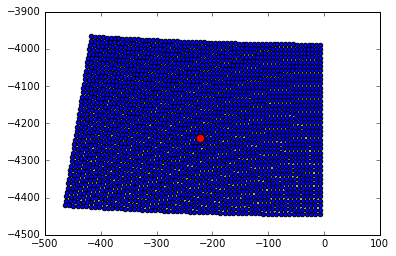

In [746]:
plt.scatter(xx, yy)
plt.scatter(xx[i,j], yy[i,j], c='red', s=70)
plt.show()


In [747]:
x0, y0 = xx[i,j],yy[i,j]

In [748]:
rr = np.sqrt((lon - x0)**2 + (lat - y0)**2)
print(rr.shape)

(2360520,)


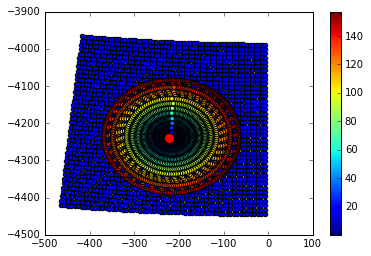

In [749]:
plt.scatter(xx, yy)


plt.scatter(lon[::300], lat[::300], c=rr[::300])
plt.colorbar()

plt.scatter(xx[i,j], yy[i,j], c='red', s=100)

plt.show()



In [750]:
print x1[rr < footprint_range].shape
print x1[rr < footprint_range].shape==(0,)

print x2[rr < footprint_range].shape
#print x2[rr < footprint_range]

(50768,)
False
(50768,)


In [751]:
np.nansum(x1[rr < footprint_range ])==0.0, np.nansum(np.array([np.nan,0,0,0.]))

(False, 0.0)

In [752]:
print np.nanargmax(x1[rr < footprint_range ]) # auf welcher position befinddet sich das maximum 

idx = np.nanargmax(x1[rr < footprint_range ]) 
print idx
print x2[rr < footprint_range ][idx]

20056
20056
2212.958738896996


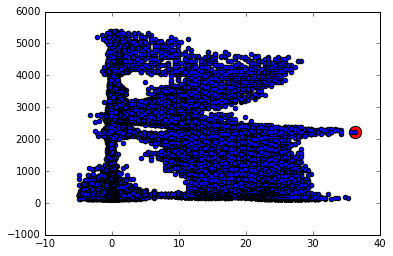

In [753]:
plt.scatter(np.nanmax(x1[rr < footprint_range ]),x2[rr < footprint_range ][idx],s=150, c='red')

plt.scatter(x1[rr < footprint_range ], x2[rr < footprint_range ])
plt.scatter(x3[rr < footprint_range ], x2[rr < footprint_range ])

plt.show()

In [754]:
bb_boxpol[i,j] = x2[rr < footprint_range ][idx]

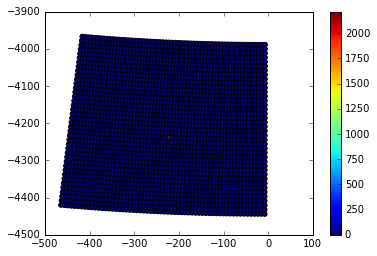

In [755]:
plt.scatter(xx,yy,c=bb_boxpol)
plt.colorbar()
plt.show()

# Test loop


In [685]:
footprint_range = 20 # footprint radius bestimmen 
bb_boxpol = np.zeros(xx.shape)

i, j = 20, 30 
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
    
        #print (i)
        x0, y0 = xx[i,j],yy[i,j] # pos definieren
        rr = np.sqrt((lon - x0)**2 + (lat - y0)**2) #abstande bestimmen
        if x1[rr < footprint_range ].shape==(0,):
            # gibt es einen nanargmax
            bb_boxpol[i,j] = np.nan

        elif np.nansum(x1[rr < footprint_range ])==0.0:
            #ist das array voll mit nan
            bb_boxpol[i,j] = np.nan

        else:    
            idx = np.nanargmax(x1[rr < footprint_range ]) # index des maximalwertes Z bestimmen
            bb_boxpol[i,j] = x2[rr < footprint_range ][idx] # die dazugehörige Höhe abspeichern



In [686]:
bb_boxpol.shape

(40, 60)

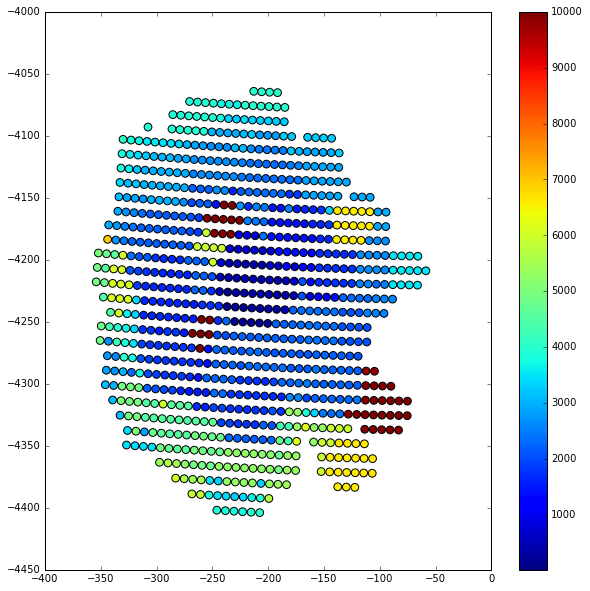

In [687]:
plt.figure(figsize=(10,10))
plt.scatter(xx,yy,c=bb_boxpol, s=60,vmin=10, vmax=10000)
plt.colorbar()
plt.show()